In [36]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import chi2_contingency # Added for statistical test
import warnings

warnings.filterwarnings("ignore")

In [37]:
# Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
target_col = 'personality_cluster'
id_col = 'participant_id'

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (1913, 14)
Test shape: (479, 13)


In [38]:
# Check for duplicates and remove if found
dup_count = train.duplicated().sum()
if dup_count > 0:
    train.drop_duplicates(inplace=True)
    print(f"\nDuplicates removed. New shape: {train.shape}")
else:
    print("\nNo exact duplicates found in train data.")


No exact duplicates found in train data.


In [39]:
## 2.1 Missing Values Check 
print("\n--- Missing Values Check ---")
missing_info = train.isnull().sum()
missing_info = missing_info[missing_info > 0].sort_values(ascending=False)
if missing_info.empty:
    print(" No missing values found in the training data.")
else:
    print("Found missing values:")
    print(missing_info)


--- Missing Values Check ---
 No missing values found in the training data.



--- Target Variable Distribution ---


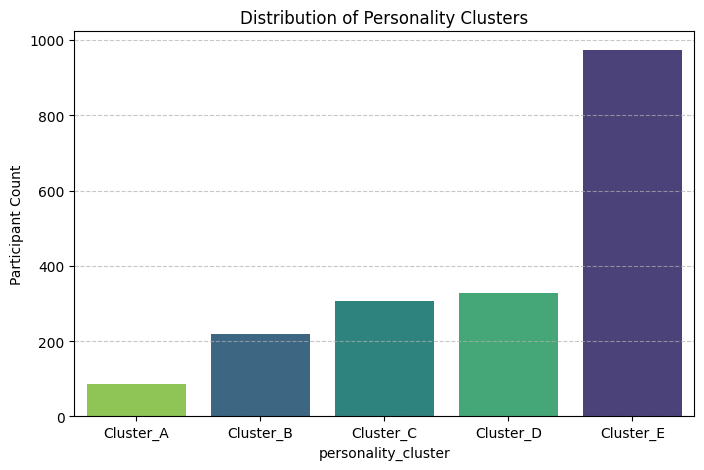

In [40]:
## 2.1 Target Variable Distribution
print("\n--- Target Variable Distribution ---")
plt.figure(figsize=(8, 5))
sns.countplot(x=target_col, hue=target_col, data=train, palette='viridis', 
              order=sorted(train[target_col].unique()), legend=False)
plt.title('Distribution of Personality Clusters')
plt.ylabel('Participant Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


--- Numerical Feature Distributions (Histograms and Boxplots) ---


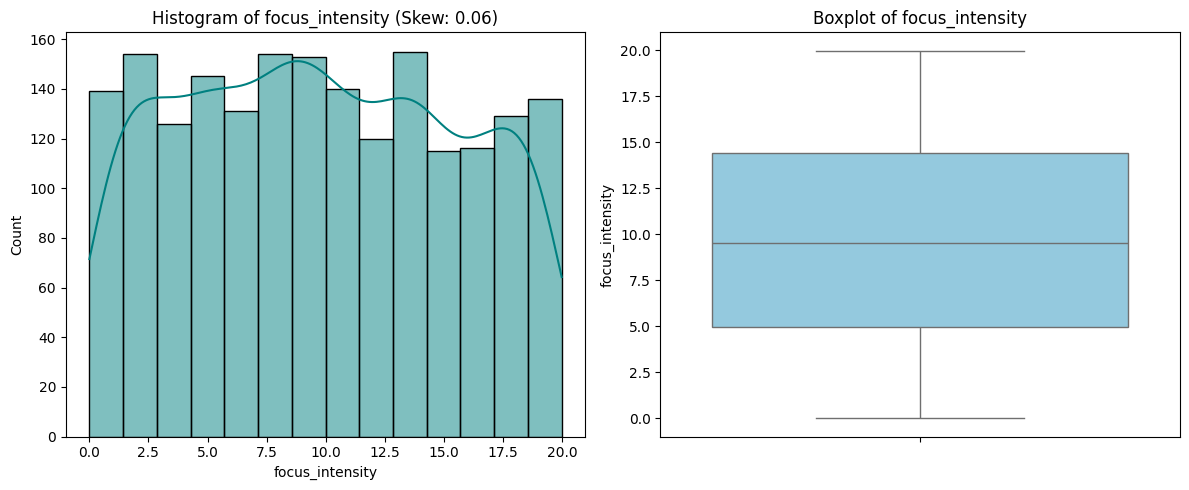

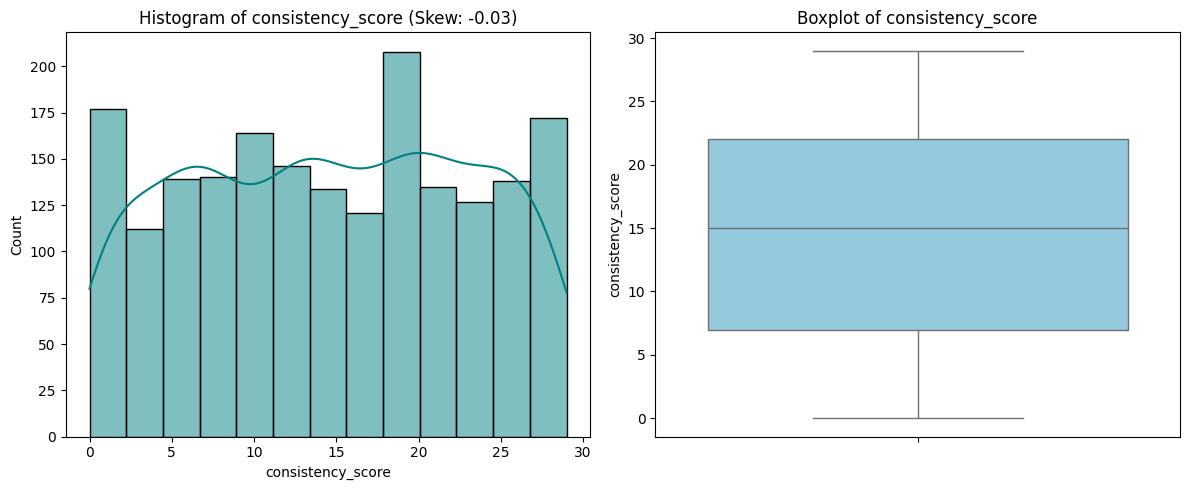

In [41]:
num_cols_for_plot = ['focus_intensity', 'consistency_score']
print("\n--- Numerical Feature Distributions (Histograms and Boxplots) ---")

for col in num_cols_for_plot:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Histogram
    sns.histplot(train[col].dropna(), kde=True, bins='auto', color='teal', ax=axes[0])
    axes[0].set_title(f'Histogram of {col} (Skew: {train[col].skew():.2f})')
    
    # Boxplot (Outlier Check)
    sns.boxplot(y=train[col], color='skyblue', ax=axes[1])
    axes[1].set_title(f'Boxplot of {col}')
    
    plt.tight_layout()
    plt.show()


--- Correlation Matrix (Numeric Features) ---


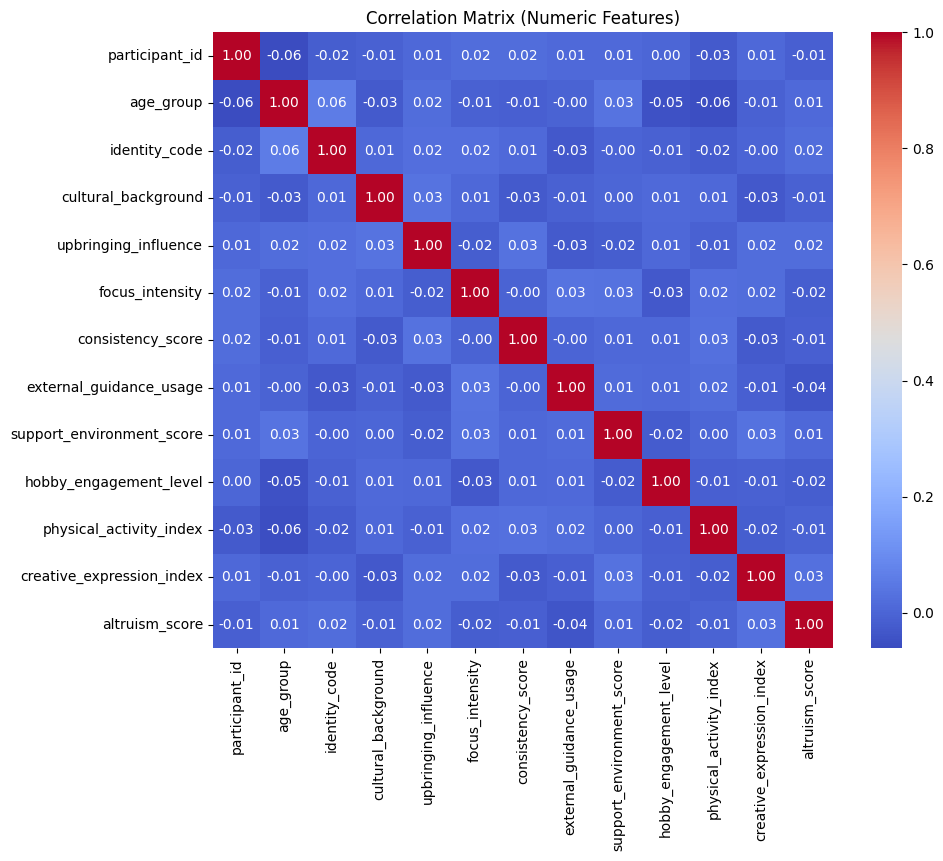

In [42]:
## 2.3 Correlation Matrix
print("\n--- Correlation Matrix (Numeric Features) ---")
numeric_features = train.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(10, 8))
sns.heatmap(train[numeric_features].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

In [43]:
cat_cols_test = [
    'age_group', 'identity_code', 'cultural_background', 
    'upbringing_influence', 'external_guidance_usage', 
    'support_environment_score', 'hobby_engagement_level',
    'physical_activity_index', 'creative_expression_index', 
    'altruism_score'
]

print(f"\n=== Chi-Square Test Results (Target: {target_col}) ===")
print(f"{'Feature':<30} | {'P-Value':<10} | {'Conclusion'}")
print("-" * 65)

results = []
for col in cat_cols_test:
    contingency_table = pd.crosstab(train[col], train[target_col])
    # Handle cases where the table is too sparse/contains zeros
    if (contingency_table.sum(axis=0).min() == 0) or (contingency_table.sum(axis=1).min() == 0):
        p = np.nan
        conclusion = "Skipped (Sparse Data)"
    else:
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        conclusion = "Significant (Keep)" if p < 0.05 else "Not Significant (Consider Dropping)"
    
    print(f"{col:<30} | {p:.5f}    | {conclusion}")
    results.append({'Feature': col, 'P-Value': p, 'Significant': p < 0.05})


=== Chi-Square Test Results (Target: personality_cluster) ===
Feature                        | P-Value    | Conclusion
-----------------------------------------------------------------
age_group                      | 0.31029    | Not Significant (Consider Dropping)
identity_code                  | 0.21584    | Not Significant (Consider Dropping)
cultural_background            | 0.51482    | Not Significant (Consider Dropping)
upbringing_influence           | 0.62792    | Not Significant (Consider Dropping)
external_guidance_usage        | 0.00000    | Significant (Keep)
support_environment_score      | 0.00000    | Significant (Keep)
hobby_engagement_level         | 0.01528    | Significant (Keep)
physical_activity_index        | 0.21303    | Not Significant (Consider Dropping)
creative_expression_index      | 0.02295    | Significant (Keep)
altruism_score                 | 0.46182    | Not Significant (Consider Dropping)


In [44]:
# Separate Features (X) and Target (y)
X = train.drop(columns=[id_col, target_col])
y = train[target_col]
X_test_final = test.drop(columns=[id_col])

# --- FIX for KeyError: 'total_activity_score' and 'support_x_guidance' ---
# The correct numerical columns are those present in X and are numeric.
# We ensure the lists only contain columns available in the DataFrame X.
all_cols_in_X = X.columns.tolist()

# Define Column Types (Corrected)
# We assume 'focus_intensity' and 'consistency_score' are the main numerical features
numerical_cols = ['focus_intensity', 'consistency_score']
# Re-create categorical/ordinal lists based on what's left in X
categorical_like_cols = [col for col in all_cols_in_X if col not in numerical_cols]

# Explicitly defining nominal and ordinal from the available categorical-like features
nominal_cols = [
    'identity_code', 'cultural_background', 'upbringing_influence', 
    'external_guidance_usage', 'support_environment_score', 'hobby_engagement_level', 
    'physical_activity_index', 'creative_expression_index', 'altruism_score'
]
ordinal_cols = ['age_group'] 

## 3.1 Create Preprocessing Pipelines
# Numerical: Impute Missing (Median) -> Standard Scale
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()) 
])

# Nominal: Impute Missing (Mode) -> One-Hot Encode
nominal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
])

# Ordinal: Impute Missing (Mode) -> Ordinal Encode
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder())
])

## 3.2 Create the Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('nom', nominal_pipeline, nominal_cols), 
        ('ord', ordinal_pipeline, ordinal_cols)
    ],
    remainder='drop' 
)
print("\n--- Preprocessor Defined and Column Names Fixed ---")

## 3.3 Fit and Transform Data
X_processed = preprocessor.fit_transform(X)
X_test_final_processed = preprocessor.transform(X_test_final)

## 3.4 Target Variable Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("\nTarget Variable Mapping (Original -> Encoded):")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


--- Preprocessor Defined and Column Names Fixed ---

Target Variable Mapping (Original -> Encoded):
{'Cluster_A': np.int64(0), 'Cluster_B': np.int64(1), 'Cluster_C': np.int64(2), 'Cluster_D': np.int64(3), 'Cluster_E': np.int64(4)}
